# K Nearest Neighbour Classification

## Introduction & Executive summary

In this notebook, you will see that we are trying to predict the price percentage direction (up/down, 1/-1) of eth and ltc based on some feature vectors of btc.

Our aim of implementing K-NN is to test our assumption that we could utilize bitcoin's information other than price, such as volume change and market capitalization change, to predict the price changes of eth and ltc. 

As results, while our model just forecast today's eth/ltc price from today's btc's market information such as price, volume, and market cap % changes, i.e. not the "prediction for tomorrow", at least we could show that we could capture the daily price direction of eth and ltc, by utilizing bitcoin's market information.

We may be able to utilize this insight for "day trading" i.e. intra-day trading in finance term. For example, at the 12 o'clock of daily market, we run this model, then, we may be able to obtain the insight about afternoon and night market direction. If we had more time, we can try such analysis as well.  

## Set up

In [1]:
#It's for google colab usage on google drive.
#Ignore or change folder path that corresponds to your environment.
from google.colab import drive 
drive.mount('/content/drive', force_remount=True)

COLAB_PATH = '/content/drive/My Drive/IT5006/FinalPackage'

import sys, os
sys.path.append(COLAB_PATH)
print(sys.path)
## change directory to the path above
os.chdir(COLAB_PATH)

Mounted at /content/drive
['', '/content', '/env/python', '/usr/lib/python37.zip', '/usr/lib/python3.7', '/usr/lib/python3.7/lib-dynload', '/usr/local/lib/python3.7/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.7/dist-packages/IPython/extensions', '/root/.ipython', '/content/drive/My Drive/IT5006/FinalPackage']


### Import Libaries 

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns
import array
import datetime
import random
from dateutil.parser import parse
from pylab import rcParams
from math import sqrt

In [3]:
#Importing K-NN related.
from sklearn.metrics import mean_squared_error 
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
import matplotlib.ticker as plticker

In [4]:
import warnings
warnings.filterwarnings('ignore')
# Here we are trying to set the float data's to 4 decimal place, following by market convention.
pd.options.display.float_format = '{:.4f}'.format

### Load Dataset

In [5]:
main_df = pd.read_csv("./team12_cleandata.csv")
main_df.describe()
del main_df['Unnamed: 0']

### Data preparation

We try to predict whether eth/ltc will go up or down in price, based on the feature vectors of btc_volume, btc_price, btc_mktcap. To do so, we prepare data, by data preprocessing.

In [6]:
#Taking only relevant data from our data infrastructure.
btc_eth_df = main_df[['day', 'btc_volume', 'btc_price', 'btc_mktcap', 'eth_price']]
btc_ltc_df = main_df[['day', 'btc_volume', 'btc_price', 'btc_mktcap', 'ltc_price']]

In [7]:
btc_eth_df.isnull().sum()

day             0
btc_volume      0
btc_price       0
btc_mktcap      0
eth_price     713
dtype: int64

In [8]:
#Droping unnecessary column of day, then taking % changes of price.
btc_eth_df = btc_eth_df.dropna().drop(columns='day').pct_change()
btc_ltc_df = btc_ltc_df.dropna().drop(columns='day').pct_change()

#eliminating nan
btc_eth_df = btc_eth_df.dropna()
btc_ltc_df = btc_ltc_df.dropna()

In [9]:
#Renaming columns to represent each data property.
btc_eth_df = btc_eth_df.rename(columns={
    "btc_volume": "btc_vol_pct_change", 
    "btc_price": "btc_price_pct_change", 
    "btc_mktcap": "btc_mktcap_pct_change",
    "eth_price": "eth_price_pct_change",
})
btc_ltc_df = btc_ltc_df.rename(columns={
    "btc_volume": "btc_vol_pct_change", 
    "btc_price": "btc_price_pct_change", 
    "btc_mktcap": "btc_mktcap_pct_change",
    "ltc_price": "ltc_price_pct_change",
})

In [10]:
#Transforming price % change into (up, down) = (1,-1) 
btc_eth_df['eth_up_down'] = np.where(btc_eth_df['eth_price_pct_change'] > 0,1,-1)
btc_ltc_df['ltc_up_down'] = np.where(btc_ltc_df['ltc_price_pct_change'] > 0,1,-1)

In [11]:
#Set btc volume % change, price % change, and market capitalization % change as feature vectors.
btc_pct_df = btc_eth_df[['btc_vol_pct_change', 'btc_price_pct_change', 'btc_mktcap_pct_change']]
btc_pct_np = btc_pct_df.to_numpy()

## K-NN Classifier 1 (Feature vectors: btc_volume, btc_price, btc_mktcap)

### ETH prediction

#### Modeling

In [12]:
#train/test split by 80/20.
X_train, X_test, y_train, y_test = train_test_split(
    btc_pct_np, 
    btc_eth_df['eth_up_down'], 
    random_state=0,
    test_size=0.2,
)

In [13]:
#By grid-search, finding best k for K-NN
params = {'n_neighbors':[i+1 for i in range(20)]}

knn = KNeighborsClassifier()

model = GridSearchCV(knn, params)
model.fit(X_train, y_train)
best_k = model.best_params_['n_neighbors']
best_k

19

In [14]:
#Modeling KNN classifier by using best_k
knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=19, p=2,
                     weights='uniform')

In [15]:
confidenceknn = knn.score(X_train, y_train)
print('The knn mean accuracy in training data is ', confidenceknn)

The knn mean accuracy in training data is  0.7300295857988166


#### Prediction based on our model

In [16]:
prediction = knn.predict(X_test)

In [17]:
prediction_df = pd.DataFrame(data=prediction, index=[x for x in range(len(prediction))], columns=['prediction'])
actual = y_test.to_numpy()
actual_df = pd.DataFrame(data=actual, index=[x for x in range(len(actual))], columns=['actual'])
concated = pd.concat([prediction_df,actual_df], axis=1)
concated

,prediction,actual
0,1,1
1,-1,1
2,1,1
3,-1,-1
4,1,1
...,...,...
334,1,1
335,-1,-1
336,1,-1
337,1,-1


#### Confusion matrix, precision/recall/F1_score

In [18]:
def evaluationFunction(y_test, X_pred, X_test):
  #classification report
  print(classification_report(y_test,X_pred))
  #confusion matrix
  plot_confusion_matrix(knn,X_test,y_test,values_format='.0f',cmap='Blues')
  #AUC
  fpr, tpr, thresholds = roc_curve(y_test,X_pred)
  auc_score = auc(fpr, tpr)
  print("AUC is ", auc_score)

              precision    recall  f1-score   support

          -1       0.61      0.59      0.60       153
           1       0.67      0.69      0.68       186

    accuracy                           0.65       339
   macro avg       0.64      0.64      0.64       339
weighted avg       0.64      0.65      0.65       339

AUC is  0.6408918406072106


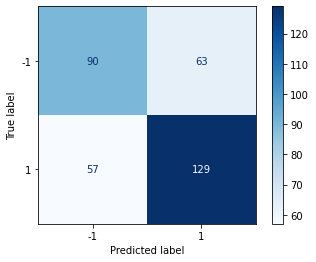

In [19]:
evaluationFunction(concated['actual'],concated['prediction'],X_test)

### LTC Prediction

#### Modeling

In [20]:
# Replace inf value to nan and then dropna
btc_ltc_df.replace([np.inf, -np.inf], np.nan, inplace=True)
btc_ltc_df = btc_ltc_df.dropna()

btc_pct_df = btc_ltc_df[['btc_vol_pct_change', 'btc_price_pct_change', 'btc_mktcap_pct_change']]
btc_pct_np = btc_pct_df.to_numpy()
btc_ltc_df

,btc_vol_pct_change,btc_price_pct_change,btc_mktcap_pct_change,ltc_price_pct_change,ltc_up_down
210,-0.5703,-0.0106,-0.0100,0.0294,1
211,-0.0852,0.0469,0.0469,0.0769,1
212,-0.1138,-0.0070,-0.0070,-0.0177,-1
213,0.0705,0.0167,0.0167,0.0059,1
214,-0.2819,0.0062,0.0062,0.0379,1
...,...,...,...,...,...
2400,0.1404,0.1143,0.1140,0.1620,1
2401,0.3491,-0.0020,0.0029,-0.0143,-1
2402,-0.2554,0.0266,0.0208,0.0214,1
2403,-0.0973,0.0110,0.0118,-0.0077,-1


In [21]:
#train/test split (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    btc_pct_np, 
    btc_ltc_df['ltc_up_down'], 
    random_state=0,
    test_size=0.2,
)

In [22]:
#By grid-search, finding best k for K-NN
params = {'n_neighbors':[i+1 for i in range(20)]}
knn = KNeighborsClassifier()
model = GridSearchCV(knn, params)
model.fit(X_train, y_train)
best_k = model.best_params_['n_neighbors']
best_k

11

In [23]:
# KNN Classifier
knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=11, p=2,
                     weights='uniform')

In [24]:
confidenceknn = knn.score(X_train, y_train)
print('The knn mean accuracy in training data is ', confidenceknn)

The knn mean accuracy in training data is  0.7932801822323462


#### Prediction based on our model

In [25]:
prediction = knn.predict(X_test)

In [26]:
prediction_df = pd.DataFrame(data=prediction, index=[x for x in range(len(prediction))], columns=['prediction'])
actual = y_test.to_numpy()
actual_df = pd.DataFrame(data=actual, index=[x for x in range(len(actual))], columns=['actual'])
concated = pd.concat([prediction_df,actual_df], axis=1)
concated

,prediction,actual
0,1,-1
1,-1,1
2,-1,1
3,1,-1
4,-1,-1
...,...,...
434,-1,-1
435,-1,1
436,-1,-1
437,-1,-1


#### Confusion matrix, precision/recall/F1_score

              precision    recall  f1-score   support

          -1       0.81      0.73      0.77       241
           1       0.71      0.79      0.75       198

    accuracy                           0.76       439
   macro avg       0.76      0.76      0.76       439
weighted avg       0.76      0.76      0.76       439

AUC is  0.7616098746804141


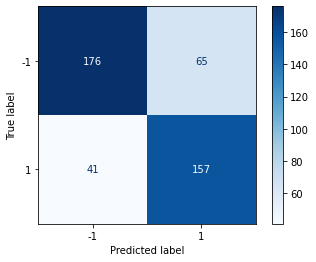

In [27]:
evaluationFunction(concated['actual'],concated['prediction'],X_test)

### Conclusion

*  Eth: We could predict precision=0.67, recall=0.69, and f1_score=0.68, which is better than 50/50 coin tossing. AUC is 0.64, better than 0.50. It implies that we can utilize bitcoin's volume and market cap information to predict eth price % changes.

*  Ltc: We could predict precision=0.71, recall=0.79, f1_score=0.75, which is better than 50/50 coin tossing and eth's prediction. AUC is 0.76, better than 0.50 and the result of eth. It reflects the similarity of currency structure and high correlation between bitcoin and ltc.

## K-NN Classifier 2 (Adding more features in feature vectors)

Also, we hypothesized that the market_cap and trade volume information of the respective digital assets can be used as the feature vector to improve the model's predictions. 

As results, unfortunately we could not improve the performance by adding features. While the training accuracy is good, the results in test data is not great. It implies that the overfitting happened by adding more features. Although the results was not great, for reference purpose, we kept our trial of adding features shown as below.

### Data preparation

In [28]:
btc_eth_df = main_df[['day', 'btc_volume_chg', 'btc_price_chg', 'btc_mktcap_chg', 'eth_price_chg', 'eth_mktcap', 'eth_volume']]
btc_ltc_df = main_df[['day', 'btc_volume_chg', 'btc_price_chg', 'btc_mktcap_chg', 'ltc_price_chg', 'ltc_mktcap', 'ltc_volume']]

In [29]:
btc_eth_df = btc_eth_df.dropna()
btc_ltc_df = btc_ltc_df.dropna()

In [30]:
btc_eth_df = btc_eth_df.rename(columns={
    "btc_volume_chg": "btc_vol_pct_change", 
    "btc_price_chg": "btc_price_pct_change", 
    "btc_mktcap_chg": "btc_mktcap_pct_change",
    "eth_price_chg": "eth_price_pct_change",
})
btc_ltc_df = btc_ltc_df.rename(columns={
    "btc_volume_chg": "btc_vol_pct_change", 
    "btc_price_chg": "btc_price_pct_change", 
    "btc_mktcap_chg": "btc_mktcap_pct_change",
    "ltc_price_chg": "ltc_price_pct_change",
})

In [31]:
btc_eth_df['eth_up_down'] = np.where(btc_eth_df['eth_price_pct_change'] > 0,1,-1)
btc_ltc_df['ltc_up_down'] = np.where(btc_ltc_df['ltc_price_pct_change'] > 0,1,-1)

In [32]:
btc_pct_df = btc_eth_df[['btc_vol_pct_change', 'btc_price_pct_change', 'btc_mktcap_pct_change', 'eth_mktcap', 'eth_volume']]
btc_pct_np = btc_pct_df.to_numpy()

### ETH prediction

#### Modeling

In [33]:
X_train, X_test, y_train, y_test = train_test_split(
    btc_pct_np, 
    btc_eth_df['eth_up_down'], 
    random_state=0,
    test_size=0.2,
)

In [34]:
params = {'n_neighbors':[i+1 for i in range(20)]}

knn = KNeighborsClassifier()

model = GridSearchCV(knn, params)
model.fit(X_train, y_train)
best_k = model.best_params_['n_neighbors']
best_k

14

In [35]:
# KNN Classifier
knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=14, p=2,
                     weights='uniform')

In [36]:
confidenceknn = knn.score(X_train, y_train)
print('The knn mean accuracy in training data is ', confidenceknn)

The knn mean accuracy in training data is  0.6050295857988166


#### Precition based on the model with added features

In [37]:
prediction = knn.predict(X_test)

In [38]:
prediction_df = pd.DataFrame(data=prediction, index=[x for x in range(len(prediction))], columns=['prediction'])
actual = y_test.to_numpy()
actual_df = pd.DataFrame(data=actual, index=[x for x in range(len(actual))], columns=['actual'])
concated = pd.concat([prediction_df,actual_df], axis=1)
concated

,prediction,actual
0,-1,1
1,1,1
2,-1,1
3,-1,-1
4,-1,-1
...,...,...
334,-1,1
335,-1,-1
336,1,-1
337,1,-1


#### Confusion matrix, precision/recall/F1_score

              precision    recall  f1-score   support

          -1       0.49      0.72      0.58       162
           1       0.54      0.30      0.39       177

    accuracy                           0.50       339
   macro avg       0.51      0.51      0.48       339
weighted avg       0.51      0.50      0.48       339

AUC is  0.510828625235405


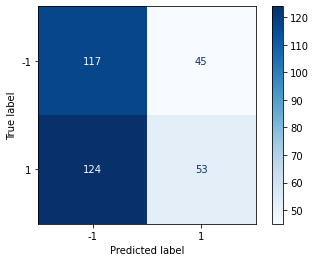

In [39]:
evaluationFunction(concated['actual'],concated['prediction'],X_test)

### LTC Prediction

#### Modeling

In [40]:
#Additional data preprocessing.
# Replace inf value to nan and then dropna
btc_ltc_df.replace([np.inf, -np.inf], np.nan, inplace=True)
btc_ltc_df = btc_ltc_df.dropna()

btc_pct_df = btc_ltc_df[['btc_vol_pct_change', 'btc_price_pct_change', 'btc_mktcap_pct_change', 'ltc_mktcap', 'ltc_volume']]
btc_pct_np = btc_pct_df.to_numpy()
btc_ltc_df.head()

,day,btc_vol_pct_change,btc_price_pct_change,btc_mktcap_pct_change,ltc_price_pct_change,ltc_mktcap,ltc_volume,ltc_up_down
210,2013-12-29,-0.0392,-0.0167,-0.0164,0.0259,563520469.0000,6729630.0000,1
211,2013-12-30,-0.0852,0.0469,0.0469,0.0769,607594563.0000,16361000.0000,1
212,2013-12-31,-0.1138,-0.0070,-0.0070,-0.0177,597517493.0000,8350680.0000,-1
213,2014-01-01,0.0705,0.0167,0.0167,0.0059,601777194.0000,8159590.0000,1
214,2014-01-02,-0.2819,0.0062,0.0062,0.0379,625306506.0000,17790500.0000,1


In [41]:
#Train test split (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    btc_pct_np, 
    btc_ltc_df['ltc_up_down'], 
    random_state=0,
    test_size=0.2,
)

In [42]:
#grid search to find the best K in the model.
params = {'n_neighbors':[i+1 for i in range(20)]}

knn = KNeighborsClassifier()
model = GridSearchCV(knn, params)
model.fit(X_train, y_train)
best_k = model.best_params_['n_neighbors']
best_k

2

In [43]:
# KNN Classifier
knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                     weights='uniform')

In [44]:
confidenceknn = knn.score(X_train, y_train)
print('The knn mean accuracy in training data is ', confidenceknn)

The knn mean accuracy in training data is  0.7522779043280182


#### Prediction

In [45]:
prediction = knn.predict(X_test)

In [46]:
prediction_df = pd.DataFrame(data=prediction, index=[x for x in range(len(prediction))], columns=['prediction'])
actual = y_test.to_numpy()
actual_df = pd.DataFrame(data=actual, index=[x for x in range(len(actual))], columns=['actual'])
concated = pd.concat([prediction_df,actual_df], axis=1)
concated

,prediction,actual
0,-1,-1
1,-1,-1
2,1,1
3,-1,1
4,1,-1
...,...,...
434,1,-1
435,-1,1
436,-1,-1
437,-1,-1


#### Confusion matrix, precision/recall/F1_score

              precision    recall  f1-score   support

          -1       0.58      0.80      0.67       242
           1       0.53      0.28      0.37       197

    accuracy                           0.57       439
   macro avg       0.56      0.54      0.52       439
weighted avg       0.56      0.57      0.54       439

AUC is  0.5408923102739439


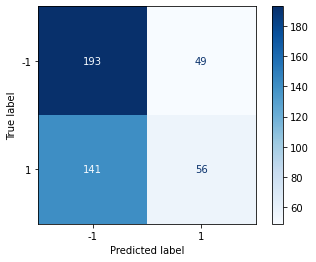

In [47]:
evaluationFunction(concated['actual'],concated['prediction'],X_test)

### Conclusion

*  Eth: Results were as follows. precision=0.54, recall=0.30, and f1_score=0.39. AUC is 0.51, almost same as 0.50. It implies that no additional features did not add value to the quality of prediction.

*  Ltc: Results were as follows. precision=0.53, recall=0.28, f1_score=0.37, AUC is 0.54, almost same as 0.50. It implies that no additional features did not add value to the quality of prediction.